# Imports 
Necessary imports, based in part on [this](https://www.kaggle.com/code/awsaf49/planttraits2024-kerascv-starter-notebook)

In [3]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch

# deep learning
import keras_cv
import keras
from keras import ops
import tensorflow as tf
import cv2
import umap.umap_ as umap

# data processing
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# stats
from sklearn.metrics import mutual_info_score
from scipy.stats import wasserstein_distance

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# misc 
from config import config

In [ ]:
import model

nn = model.Model("model1")

print(nn.name) # model1

# Data pre-processing

## Loading
The general format of each instance of the data is 
```
[ids*, ancillary data*, trait means*, traits sd*, image path]
```

In [4]:
from config import config
DATA_PATH = "../data"

# creating df that has image path and related ancillary data
df = pd.read_csv(DATA_PATH + "/train.csv")
df['image_path'] = f'{DATA_PATH}/train_images/' + df['id'].astype(str) + '.jpeg'
df.loc[:, config.aux_class_names] = df.loc[:, config.aux_class_names].fillna(-1)
display(df.head(2))
print(df.shape[0]) 

# same df but for the test data
test_df = pd.read_csv(DATA_PATH + "/test.csv")
test_df['image_path'] = f'{DATA_PATH}/test_images'+ test_df['id'].astype(str) + '.jpeg'
FEATURE_COLS = list(test_df.columns[1:-1])
display(test_df.head(2))
print(test_df.shape[0])

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,image_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054,../data/train_images/192027691.jpeg
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477,../data/train_images/195542235.jpeg


55489


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12,image_path
0,195066138,10.55810,961.500000,31.586735,13.728325,648.038208,25.351532,127,152,137,...,0.469694,0.455849,0.528211,0.555653,0.549882,0.542905,0.517507,0.462724,0.427107,../data/test_images195066138.jpeg
1,195524180,7.00287,1120.025513,23.000000,7.258863,973.889404,39.135712,106,167,127,...,0.428838,0.456266,0.470074,0.468038,0.475943,0.483206,0.477197,0.432732,0.423728,../data/test_images195524180.jpeg


13873


## traits

### mean traits

,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean
0,0.401753,11.758108,0.117484,1.243779,1.849375,50.216034
1,0.480334,15.748846,0.389315,0.642940,1.353468,574.098472


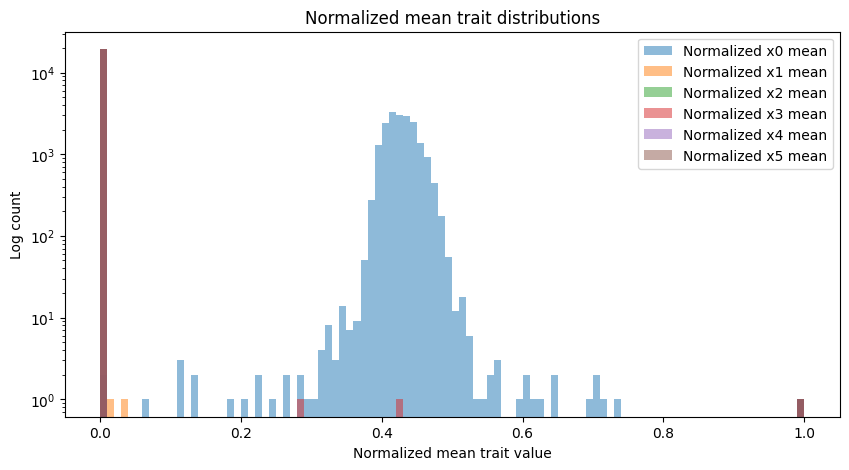

In [45]:
mean_traits = df.iloc[:, 164:170]
sd_traits = df.iloc[:, 170:176]
display(mean_traits.head(2))


def mean_normalizer(col):
    mean = mean_traits.iloc[:, col]
    mean = mean.drop_duplicates()
    return (mean - mean.min()) / (mean.max() - mean.min())

plt.figure(figsize=(10, 5))
for i in range(6): 
    plt.hist(mean_normalizer(i), log=True, bins=100, alpha=0.5, label=f'Normalized x{i} mean')
    
plt.title('Normalized mean trait distributions')
plt.xlabel('Normalized mean trait value')
plt.ylabel('Log count')
plt.legend()
plt.show()

19009


Text(0, 0.5, 'Instance count')

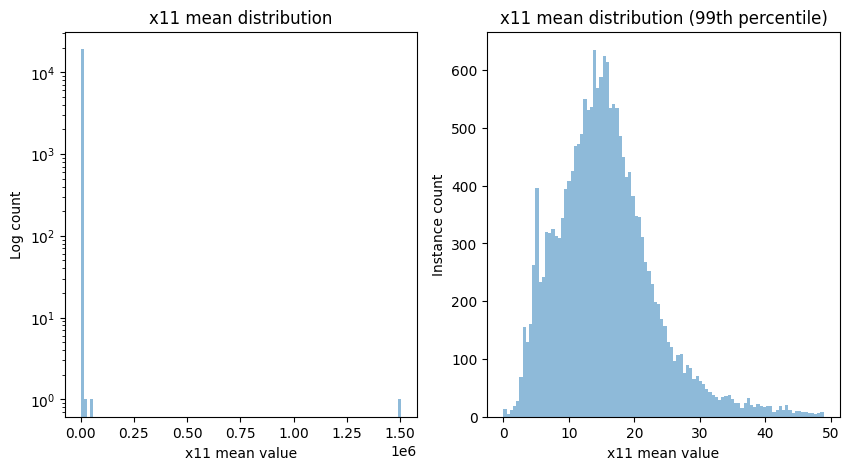

In [46]:
x_11_mean = mean_traits.iloc[:, 1]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# remove outliers
x_11_mean = x_11_mean[x_11_mean.between(x_11_mean.quantile(0), x_11_mean.quantile(1))]

x_11_mean = x_11_mean.drop_duplicates()

ax[0].hist(x_11_mean, bins=100, log=True, alpha=0.5)
ax[0].set_title('x11 mean distribution')
ax[0].set_xlabel('x11 mean value')
ax[0].set_ylabel('Log count')

x_11_mean = x_11_mean[x_11_mean.between(x_11_mean.quantile(0), x_11_mean.quantile(0.99))]
print(x_11_mean.count())
ax[1].hist(x_11_mean, bins=100, alpha=0.5)
ax[1].set_title('x11 mean distribution (99th percentile)')
ax[1].set_xlabel('x11 mean value')
ax[1].set_ylabel('Instance count')

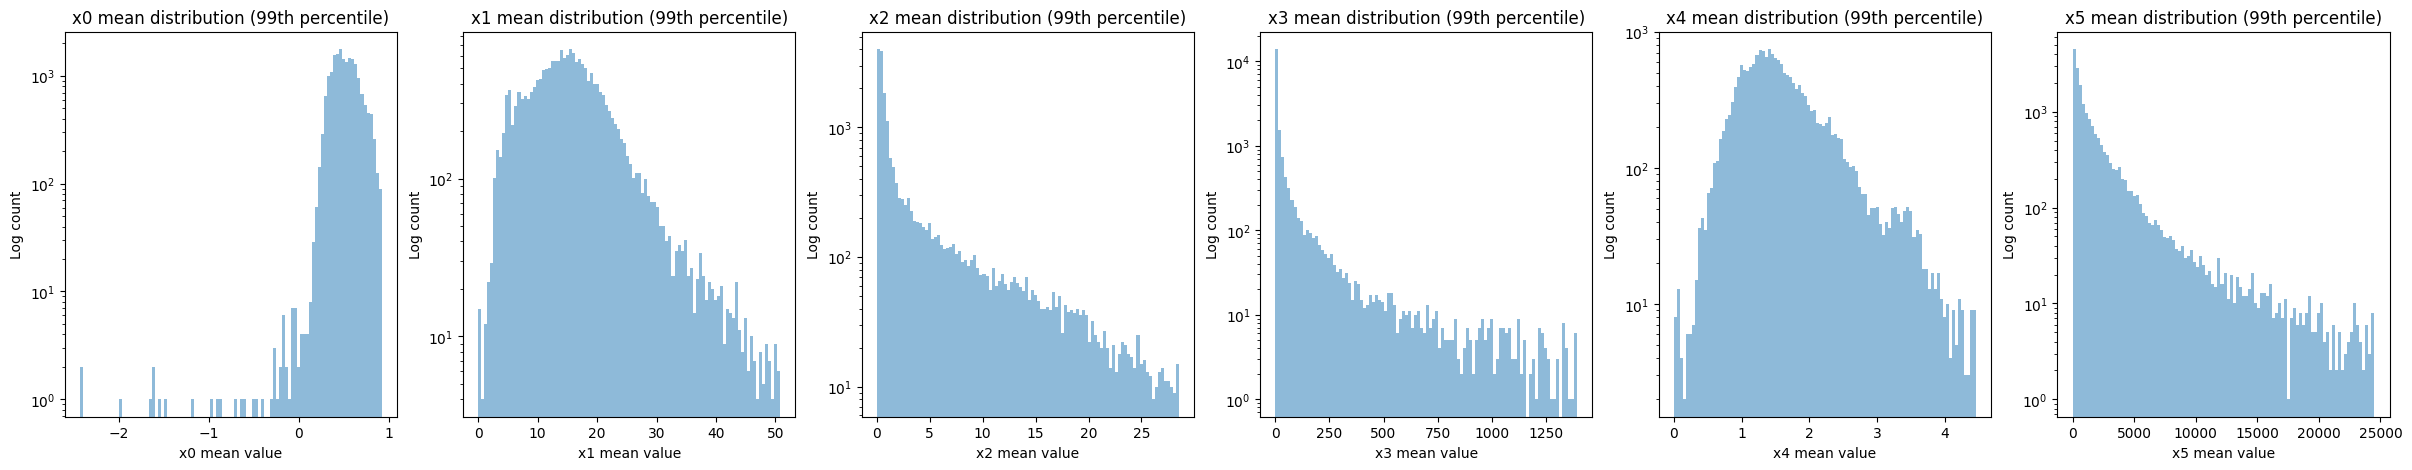

In [47]:
fig, ax = plt.subplots(1, 6, figsize=(30, 5))

for i in range(6):
    x_mean = mean_traits.iloc[:, i]
    x_mean = x_mean[x_mean.between(x_mean.quantile(0), x_mean.quantile(0.99))]
    x_mean = x_mean.drop_duplicates()
    
    ax[i].hist(x_mean, bins=100, log=True, alpha=0.5, label=f'Normalized x{i} mean')
    ax[i].set_title(f'x{i} mean distribution (99th percentile)')
    ax[i].set_xlabel(f'x{i} mean value')
    ax[i].set_ylabel('Log count')

This gives us some idea of the distribution of the targets we are training for. One thing to consider is that this distribution of traits might not be representative of the general traits of plant species. 
*Notes*
- we can maybe check some location data to see where most of the images came from to see if certain traits indicate a geographic bias 

### sd traits

In [ ]:
sd_traits = df.iloc[:, 170:176]
display(sd_traits.head(2))
def sd_normalizer(col):
    sd = sd_traits.iloc[:, col]
    return (sd - sd.min()) / (sd.max() - sd.min())

plt.figure(figsize=(10, 5))
for i in range(6):  
    plt.hist(sd_normalizer(i), log=True, bins=100, alpha=0.5, label=f'Normalized SD x{i}')

plt.title('Normalized standard deviation trait distributions')
plt.legend()
plt.show()


This might be an even better representative that we are training towards a biased sample. Intuitively I'd assume that traits would probably have a large variance if we have a geographic diversity in our sample, but here it seems this is less so the case for most of the deviations maybe ?

## ancillary data

In [ ]:
ancillary_data = df.iloc[:, 1:164]

fig = plt.figure(figsize=(10, 10))

# worldclim 
worldclim = ancillary_data.filter(like='WORLDCLIM')

g = sns.pairplot(worldclim, diag_kind='kde', plot_kws={'alpha': 0.5})

# remove labels 
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

In [ ]:
worldclim = ancillary_data.filter(like='WORLDCLIM')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
corr = worldclim.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True)
ax.set_title('Worldclim feature correlation heatmap')

high_corr = [i for i in corr[corr > 0.9].stack().index.tolist() if i[0] != i[1]]
high_corr = list(set([tuple(sorted(i)) for i in high_corr]))

scaled_worldclim_data = (worldclim - worldclim.min()) / (worldclim.max() - worldclim.min())
print(high_corr)

# PCA
pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(scaled_worldclim_data)

fig = plt.figure(figsize=(20, 10))

# Plot PCA
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=pca_result[:, 0], cmap='viridis', s=10)
ax1.set_title('PCA of worldclim features')

reconstructed_pca = pca.inverse_transform(pca_result)
loss_pca = np.mean((scaled_worldclim_data - reconstructed_pca) ** 2)

print(f'PCA Reconstruction Loss: {loss_pca}')

# UMAP
reducer = umap.UMAP(n_components=3)
embedding = reducer.fit_transform(scaled_worldclim_data)

# Plot UMAP
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=embedding[:, 0], cmap='viridis', s=10)
ax2.set_title('UMAP embedding of worldclim features')

reconstructed_umap = reducer.inverse_transform(embedding)
loss_umap = np.mean((scaled_worldclim_data - reconstructed_umap) ** 2)

print(f'UMAP Reconstruction Loss: {loss_umap}')

plt.show()

So we start of by just looking at worldclim subset of our training data and testing out some of the basic methods we are going to then use on the broader dataset, namely finding correlations and then comparing the performance of PCA vs UAMP in the dimensionality reduction.

In [ ]:
ancillary_data = df.iloc[:, 1:164]
 
# select allcolumns with a name containing WORLDCLIM
worldclim   = ancillary_data.filter(like='WORLDCLIM')
soil        = ancillary_data.filter(like='SOIL')
modis       = ancillary_data.filter(like='MODIS')
vod         = ancillary_data.filter(like='VOD')

print(
    f"lengths {len(worldclim.columns)}, {len(soil.columns)}, {len(modis.columns)}, {len(vod.columns)}"
)
    

In [ ]:
# 3 x 1 subplot of correlation heatmaps 
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# soil 

soil_corr = soil.corr()
sns.heatmap(soil_corr, ax=ax[0], cmap='coolwarm', annot=False)

ax[0].set_title('Soil feature correlation heatmap')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

# modis

modis_corr = modis.corr()
sns.heatmap(modis_corr, ax=ax[1], cmap='coolwarm', annot=False)

ax[1].set_title('MODIS feature correlation heatmap')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

# vod

vod_corr = vod.corr()
sns.heatmap(vod_corr, ax=ax[2], cmap='coolwarm', annot=False)

ax[2].set_title('VOD feature correlation heatmap')
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])

fig.tight_layout()
plt.show()

In [ ]:
correlations = [worldclim.corr(), soil.corr(), modis.corr(), vod.corr()]

high_corr = [] 

for corr in correlations:
    high_corr += [
        i for i in corr[corr > 0.9].stack().index.tolist() if i[0] != i[1]
    ]
    
mod_corr = []

for corr in correlations:
    mod_corr += [
        i for i in corr[corr > 0.65].stack().index.tolist() if i[0] != i[1]
    ]
    
total_cols = 164 
all_comb_num = total_cols * (total_cols - 1) / 2
    
high_corr = list(set([tuple(sorted(i)) for i in high_corr]))
print(
    f'num combinations with high correlation: {len(high_corr)}' + 
    f' ({len(high_corr) / all_comb_num * 100:.2f}%)' +
    f' tot = {all_comb_num}' 
)
print(
    f'num combinations with moderate correlation: {len(mod_corr)}' +
    f' ({len(mod_corr) / all_comb_num * 100:.2f}%)' +
    f' tot = {all_comb_num}'
)

In [ ]:
import config

scaler = StandardScaler()
ancillary_data = df.iloc[:, 1:164]

# random sample of ancillary data subset 
ancillary_data = scaler.fit_transform(ancillary_data)

# PCA 
pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(ancillary_data)

# UMAP
reducer = umap.UMAP(n_components=30)
embedding = reducer.fit_transform(ancillary_data)

## missing data

In [ ]:
# iter over all rows in df and look for missing data

bad_rows = []
incomplete_cols = [n for n in config.aux_class_names if n.startswith("X") and n.endswith("_sd")]  # there is some missing data in the X*_sd columns
for i, row in df.iterrows():
    # check if any of those is a 0, -1 or 1
    if row[incomplete_cols].isin([0, -1, 1]).any():
        bad_rows.append(i)
        # replace them with nans instead
        df.loc[i, incomplete_cols] = np.nan

# remove duplicates
bad_rows = set(bad_rows)
percentage_bad = len(bad_rows) / len(df) * 100
print(f"Found {len(bad_rows)} bad rows ({len(bad_rows)}/{len(df)}) ({percentage_bad:.2f}%)")

# display top 5 bad rows
missing_data_df = df.iloc[list(bad_rows)]
missing_data_df.tail(5)

### where ?

Features marked as `X*_sd` are missing for almost 30% of the data (16387/55489) (29.53%). The rest of the data seems to be complete, with no other missing/zeroed values. We can ignore these rows, or we can simply ignore those features as it is a significant amount of data.

## data augmentation

### imputation of missing values

In [ ]:
# use KNN to try to fill the X*_sd columns
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, missing_values=-1, weights='distance', metric='nan_euclidean')

tabular = df.iloc[:, 170:176]
imputed_tabluar = imputer.fit_transform(tabular)
imputed_df = pd.DataFrame(imputed_tabluar)


In [ ]:
imputed_df = imputed_df.rename(columns={i: f"{config.aux_class_names[i]}_sd" for i in range(6)})
df = pd.concat([df.iloc[:, :170], imputed_df, df['image_path']], axis=1)

# save the imputed data to a new csv in 'data/test_knn_imputed.csv'
df.to_csv(DATA_PATH + '/train_knn_imputed.csv', index=False)

display(df.head(5))

### images

In [ ]:
# slice the df to only include the columns we want
img_df = df[["image_path"] + config.class_names]
# sample 5 rows 
img_df = img_df.sample(5)

img, traits = list(img_df["image_path"].values), list(img_df[config.class_names].values)

num_imgs, num_cols = 5, 5

plt.figure(figsize=(5 * num_cols, num_imgs // num_cols * 5))
for i, (img, traits) in enumerate(zip(img, traits)):
    plt.subplot(num_imgs // num_cols, num_cols, i + 1)
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    formatted_tar = "\n".join(
        [
            ", ".join(
                f"{name.replace('_mean','')}: {val:.2f}"
                for name, val in zip(config.class_names[j : j + 3], traits[j : j + 3])
            )
            for j in range(0, len(config.class_names), 3)
        ]
    )
    
    plt.imshow(img)
    plt.title(f"[{formatted_tar}]")
    plt.axis("off")
        
plt.show()

In [ ]:
# possibly some augmenation / feature enhancing

## data split

In [5]:
from config import config
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=config.num_folds, shuffle=True, random_state=42)

# Create separate bin for each traits
for i, trait in enumerate(config.class_names):
    bin_edges = np.percentile(df[trait], np.linspace(0, 100, config.num_folds + 1))
    df[f"bin_{i}"] = np.digitize(df[trait], bin_edges)

df["final_bin"] = (
    df[[f"bin_{i}" for i in range(len(config.class_names))]]
    .astype(str)
    .agg("".join, axis=1)
)

# Perform the stratified split using final bin
df = df.reset_index(drop=True)
for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df["final_bin"])):
    df.loc[valid_idx, "fold"] = fold

/home/applesauce/vu-ml-project/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X3112_sd,image_path,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,final_bin,fold
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,15.045054,../data/train_images/192027691.jpeg,2,2,1,2,4,1,221241,2.0
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,11.004477,../data/train_images/195542235.jpeg,3,3,2,2,2,3,332223,1.0


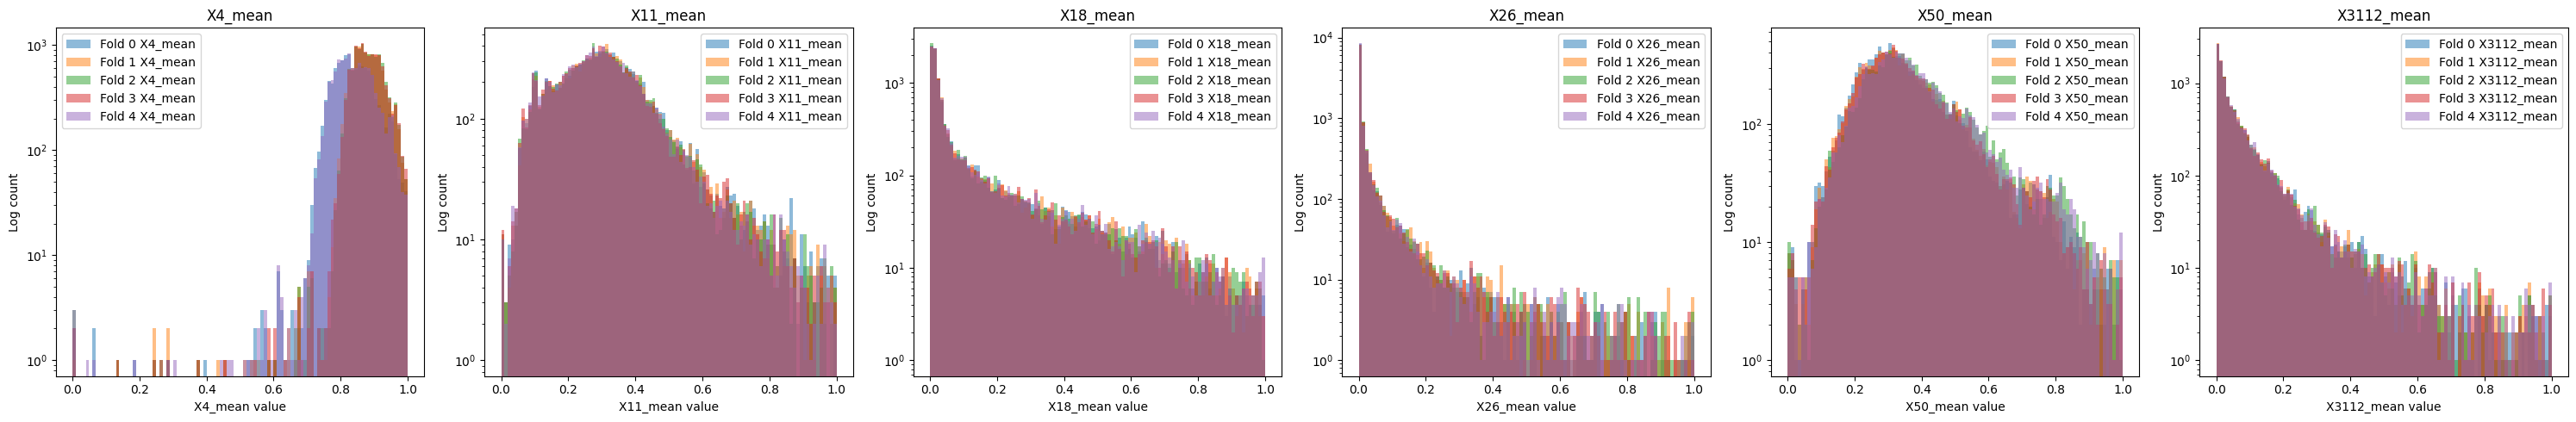

In [6]:
fig, ax = plt.subplots(1, 6, figsize=(30, 5))

display(df.head(2))

avg_hist = {i: [] for i in range(6)}

for j in range(5):
    for i in range(6):
        fold_n = df[df["fold"] == j]
        plt_df = fold_n[config.class_names[i]]
        
        plt_df = plt_df[plt_df.between(plt_df.quantile(0), plt_df.quantile(0.99))]
        
        avg_hist[i].append(plt_df)
        plt_df = (plt_df - plt_df.min()) / (plt_df.max() - plt_df.min())
        
        ax[i].hist(plt_df, bins=100, log=True, alpha=0.5, label=f"Fold {j} {config.class_names[i]}")
        ax[i].set_title(config.class_names[i])
        ax[i].set_xlabel(f"{config.class_names[i]} value")
        ax[i].set_ylabel("Log count")
        ax[i].legend()
    
    
fig.tight_layout()
plt.show()

Cool ok so we know that visually the traits are equally distributed in the different folds, so that confirms that, now it might make sense to like quantifably check this. We can I think just average the histograms then compare the distance (I think its called?) with that of the original distribution.

In [7]:
import pprint
print(list(avg_hist.values())[0][1].shape)
x4 = list(avg_hist.values())[0][1]
# print nan in x4
series_list = list(avg_hist.values())

series_list = list(map(lambda x: pd.DataFrame(x).sum(axis=0) / 5, series_list))

for i in range(6):
    print(series_list[i].isna().sum())

(10988,)


0
0
0
0
0
0


Distribution difference for X4_mean: 0.7761379612690126
Distribution difference for X11_mean: 2.82524732898307
Distribution difference for X18_mean: 0.5200729579615024
Distribution difference for X26_mean: 7.194992585373712
Distribution difference for X50_mean: 0.03845122658298907
Distribution difference for X3112_mean: 363.3889291321325


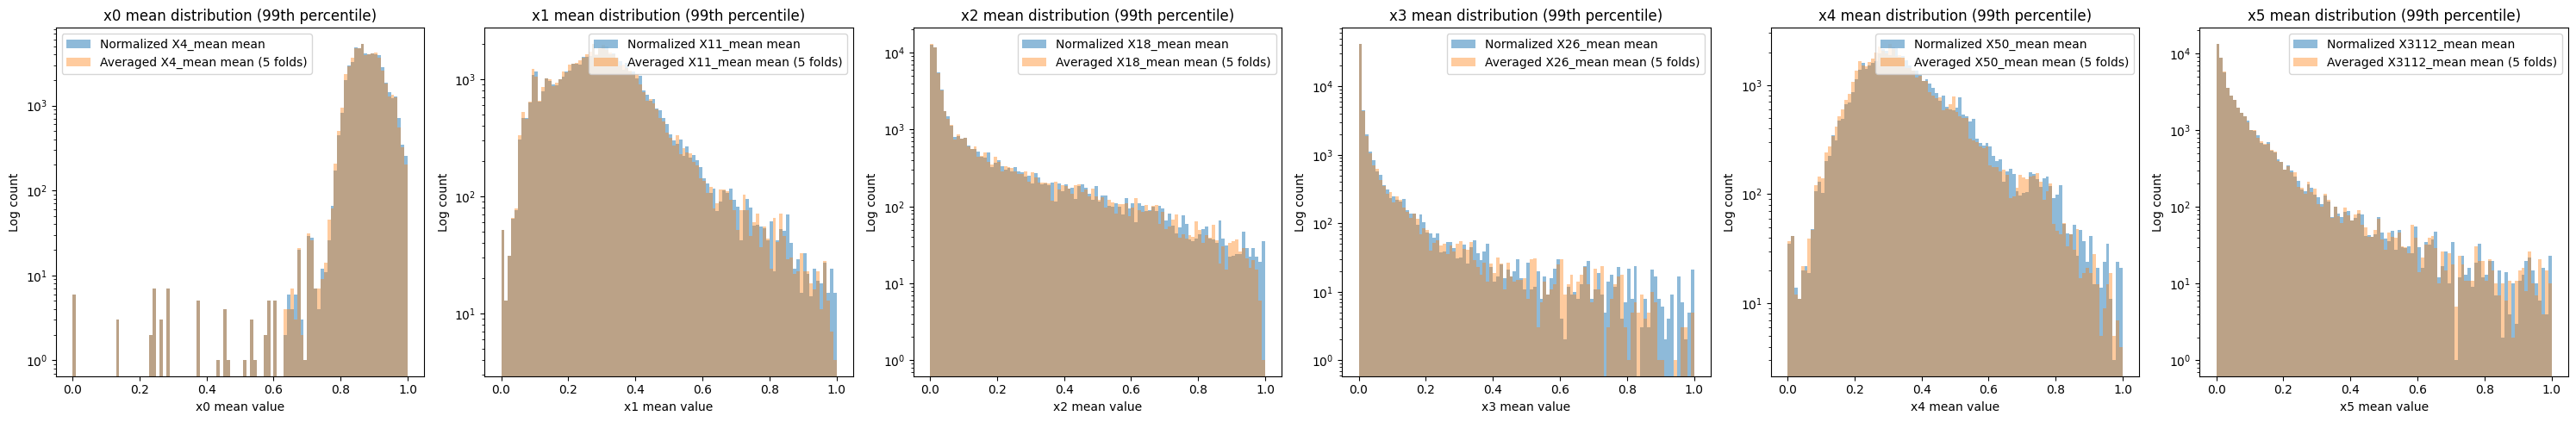

In [16]:
mean_traits = df.iloc[:, 164:170]

fig, ax = plt.subplots(1, 6, figsize=(30, 5))

for i, (x_mean_col, avrg_mean) in enumerate(zip(mean_traits.columns, series_list)):
    x_mean = mean_traits[x_mean_col]
    x_mean = x_mean[x_mean.between(x_mean.quantile(0), x_mean.quantile(0.99))]
    x_mean = (x_mean - x_mean.min()) / (x_mean.max() - x_mean.min())

    avrg_mean = avrg_mean[:54934]

    # TODO - maybe use something better than wasserstein distance to eval the distributions
    print(f"Distribution difference for {config.class_names[i]}: {wasserstein_distance(x_mean, avrg_mean)}")

    avrg_mean = (avrg_mean - avrg_mean.min()) / (avrg_mean.max() - avrg_mean.min())
    ax[i].hist(x_mean, bins=100, log=True, alpha=0.5, label=f"Normalized {config.class_names[i]} mean")
    ax[i].hist(avrg_mean, bins=100, log=True, alpha=0.4, label=f"Averaged {config.class_names[i]} mean (5 folds)")
    ax[i].set_title(f"x{i} mean distribution (99th percentile)")
    ax[i].set_xlabel(f"x{i} mean value")
    ax[i].set_ylabel("Log count")
    ax[i].legend()

fig.tight_layout()
plt.show()

# Model design

## loss function

In [9]:
# loss function for model
from loss import R2Loss, R2Metric, adjusted_R2Loss

# testing r2
y_true = np.array([1, 2, 3, 4, 5])
y_pred = np.array([1, 1, 3, 4, 5])

r2 = R2Metric()
r2.update_state(y_true, y_pred)
print(r2.result())

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


0.9


## image model

In [10]:
# outline for the image model

### backbone comparison

In [11]:
# comparing differen backbones

### evaluation + tuning

In [12]:
# evaluting model and tuning hyperparameters

## ensemble model

In [13]:
# outline for the ensemble model

### evaluation + tuning

In [14]:
# evaluating ensemble model and tuning hyperparameters